In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from preprocessing import make_preprocessor

In [2]:
df = pd.read_csv("train.csv")

Price distribution

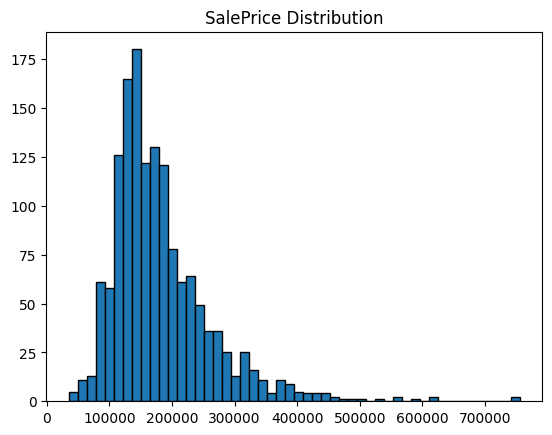

1.8828757597682129

In [3]:
plt.hist(df['SalePrice'], bins=50, edgecolor="black")
plt.title("SalePrice Distribution")
plt.show()
df['SalePrice'].skew()

We change to log scale to reduce right-skewness and stabilize variance

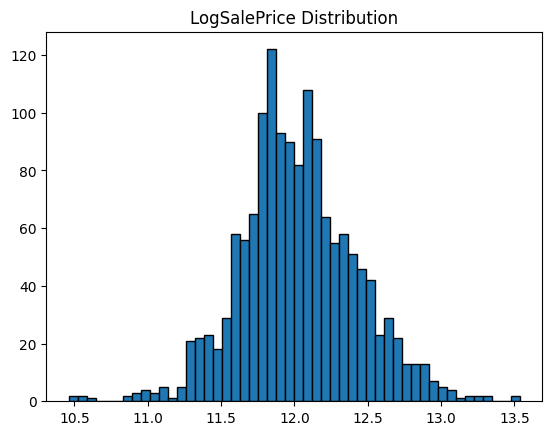

0.12134661989685329

In [4]:
df['LogSalePrice'] = np.log1p(df['SalePrice'])

plt.hist(df['LogSalePrice'], bins=50, edgecolor="black")
plt.title("LogSalePrice Distribution")
plt.show()
df['LogSalePrice'].skew()

In [5]:
y = df['LogSalePrice'].to_numpy()
X = df.drop(columns=['SalePrice', 'LogSalePrice', 'Id'])

In [6]:
X_train, X_valid, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Preprocessing
implemented in `preprocessing.py`

In [7]:
preprocessor = make_preprocessor(X_train)
X_train = preprocessor.fit_transform(X_train)
feature_names = preprocessor.named_steps["encode"].get_feature_names_out()

X_valid = preprocessor.transform(X_valid)

print(X_train.shape)

(1168, 166)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Feature Selection
implemented in `feature_selection.py`

---

In [8]:
from feature_selection import StaticFeatureSelection, DynamicFeatureSelection

### Static FS (not requiring SalePrice)

In [9]:
fs = StaticFeatureSelection(X_train, feature_names)

#### Correlation

In [10]:
fs.feature_correlation(threshold=0.9)

Found 22 correlated pairs!


In [11]:
fs.correlation_pairs

[('GarageYrBlt', 'GarageQual', 0.945668673408116),
 ('GarageYrBlt', 'GarageCond', 0.9485514913718017),
 ('GarageYrBlt', 'GarageType_NoGarage', 0.9985790443557712),
 ('GarageQual', 'GarageCond', 0.959395604861356),
 ('GarageQual', 'GarageType_NoGarage', 0.9417149480103747),
 ('GarageCond', 'GarageType_NoGarage', 0.9456281296070835),
 ('BldgType_2fmCon', 'MSSubClass_190', 0.9821763061847573),
 ('BldgType_Duplex', 'MSSubClass_90', 1.0),
 ('CentralAir_N', 'CentralAir_Y', 1.0000000000000002),
 ('Exterior1st_CBlock', 'Exterior2nd_CBlock', 1.0),
 ('Exterior1st_CemntBd', 'Exterior2nd_CmentBd', 0.9650230347341636),
 ('Exterior1st_MetalSd', 'Exterior2nd_MetalSd', 0.9727024156124735),
 ('Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 0.9740085494453824),
 ('HouseStyle_1.5Fin', 'MSSubClass_50', 0.934193607279743),
 ('HouseStyle_1.5Unf', 'MSSubClass_45', 0.9120822716378403),
 ('HouseStyle_SLvl', 'MSSubClass_80', 0.9273566791165484),
 ('MiscFeature_None', 'MiscFeature_Shed', 0.9419925822830003),
 ('Ro

#### Based on the above, columns to drop:

In [12]:
DROP_ONE_HOT_COMPLEMENTS = [
    "CentralAir_N",      # complement of CentralAir_Y
    "Street_Grvl",       # complement of Street_Pave
    "Utilities_NoSeWa",  # complement of Utilities_AllPub
]

# duplicates caused by dataset design
DROP_STRUCTURAL_REDUNDANCY = [
    # MSSubClass fully determines these
    "BldgType_Duplex",
    "BldgType_2fmCon",

    # SaleType captures new construction more directly
    "SaleCondition_Partial",

    # Garage presence encoded elsewhere
    "GarageType_NoGarage",
]

# encodings of the same physical quantity
DROP_SECONDARY_SIZE_FEATURES = [
    # Prefer capacity over area
    "GarageArea",

    # Total living area is more expressive than room count
    "TotRmsAbvGrd",
]

# Redundant categorical pairs
DROP_REDUNDANT_CATEGORIES = [
    # Exterior2nd usually mirrors Exterior1st
    "Exterior2nd_AsbShng",
    "Exterior2nd_CBlock",
    "Exterior2nd_CmentBd",
    "Exterior2nd_HdBoard",
    "Exterior2nd_MetalSd",
    "Exterior2nd_VinylSd",
    "Exterior2nd_Wd Sdng",
]

# variables dominated by absence indicators
DROP_QUALITY_WHEN_ABSENCE_IMPLIED = [
    # Condition and quality collapse when feature does not exist
    "GarageCond",
    "GarageQual",
]

# Final drop list
CORRELATION_FEATURES_TO_DROP = (
    DROP_ONE_HOT_COMPLEMENTS
    + DROP_STRUCTURAL_REDUNDANCY
    + DROP_SECONDARY_SIZE_FEATURES
    + DROP_REDUNDANT_CATEGORIES
    + DROP_QUALITY_WHEN_ABSENCE_IMPLIED
)

#### Variance threshold

In [13]:
fs.variance_threshold(threshold=0.00086)

In [14]:
fs.low_variance

array(['Condition1_RRNe', 'Condition2_PosA', 'Condition2_RRAe',
       'Condition2_RRAn', 'Condition2_RRNn', 'Exterior1st_AsphShn',
       'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_CBlock', 'Exterior2nd_Other', 'Heating_Floor',
       'MiscFeature_TenC', 'Neighborhood_Blueste', 'RoofMatl_ClyTile',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'Utilities_AllPub',
       'Utilities_NoSeWa'], dtype=object)

In [15]:
VARIANCE_FEATURES_TO_DROP = fs.low_variance

---

### Dynamic (Requiring SalesPirce)

In [16]:
dfs = DynamicFeatureSelection(X_train, y_train, feature_names)

#### F Score

In [17]:
f_test_scores = dfs.calculate_f_test()[::-1]
print(f_test_scores)

               Feature      F-Score
248   MiscFeature_Gar2     0.001561
247      LotConfig_FR2     0.007165
246  RoofStyle_Mansard     0.008337
245   Foundation_Stone     0.011779
244      MSSubClass_80     0.013155
..                 ...          ...
4            ExterQual   900.678110
3          KitchenQual   939.235474
2           GarageCars  1027.680019
1            GrLivArea  1053.840141
0          OverallQual  2192.066010

[249 rows x 2 columns]


In [18]:
feature_names[f_test_scores[f_test_scores['F-Score']<0.1].index]

array(['Utilities_NoSeWa', 'Utilities_AllPub', 'Street_Pave',
       'Street_Grvl', 'SaleType_WD', 'SaleType_Oth', 'SaleType_New',
       'SaleType_ConLw', 'SaleType_ConLI', 'SaleType_ConLD',
       'SaleType_Con', 'SaleType_CWD', 'SaleType_COD'], dtype=object)

In [19]:
FTEST_FEATURES_TO_DROP = feature_names[f_test_scores[f_test_scores['F-Score']<0.1].index]

#### Mutual Information

In [20]:
mi_scores = dfs.calculate_mutual_info()[::-1]
print(mi_scores)

               Feature  MI-Score
248          MoSold_10  0.000000
247           MoSold_5  0.000000
246           MoSold_6  0.000000
245  Exterior2nd_Stone  0.000000
244           MoSold_8  0.000000
..                 ...       ...
4            YearBuilt  0.338054
3           GarageCars  0.361780
2           GarageArea  0.362080
1            GrLivArea  0.446791
0          OverallQual  0.532272

[249 rows x 2 columns]


In [21]:
feature_names[mi_scores[mi_scores['MI-Score']<0.00001].index]

array(['Utilities_NoSeWa', 'Utilities_AllPub', 'Street_Pave',
       'Street_Grvl', 'SaleType_WD', 'SaleType_Oth', 'SaleType_New',
       'SaleType_ConLw', 'SaleType_ConLI', 'SaleType_ConLD',
       'SaleType_Con', 'SaleType_CWD', 'SaleType_COD',
       'SaleCondition_Partial', 'SaleCondition_Normal',
       'SaleCondition_Family', 'SaleCondition_Alloca',
       'SaleCondition_AdjLand', 'SaleCondition_Abnorml', 'RoofStyle_Shed',
       'RoofStyle_Mansard', 'RoofStyle_Hip', 'RoofStyle_Gambrel',
       'RoofStyle_Gable', 'RoofStyle_Flat', 'RoofMatl_WdShngl',
       'RoofMatl_WdShake', 'RoofMatl_Tar&Grv', 'RoofMatl_Roll',
       'RoofMatl_Metal', 'RoofMatl_CompShg', 'RoofMatl_ClyTile',
       'Neighborhood_Veenker', 'Neighborhood_Timber',
       'Neighborhood_StoneBr', 'Neighborhood_Somerst',
       'Neighborhood_SawyerW', 'Neighborhood_Sawyer',
       'Neighborhood_SWISU', 'Neighborhood_OldTown',
       'Neighborhood_NridgHt', 'Neighborhood_NoRidge',
       'Neighborhood_NWAmes', 'Neighb

In [22]:
MI_FEATURES_TO_DROP = feature_names[mi_scores[mi_scores['MI-Score']<0.00001].index]

### Final features to drop list

In [23]:
FEATURES_TO_DROP = set(list(MI_FEATURES_TO_DROP) + list(FTEST_FEATURES_TO_DROP) +
    list(VARIANCE_FEATURES_TO_DROP) + list(CORRELATION_FEATURES_TO_DROP))

print(FEATURES_TO_DROP)
print('-'*25)
print(f'Total features to drop (out of 249):  {len(FEATURES_TO_DROP)}')

{'CentralAir_N', 'RoofStyle_Hip', 'SaleType_New', 'Utilities_NoSeWa', 'Neighborhood_Sawyer', 'Neighborhood_Edwards', 'SaleType_Oth', 'TotRmsAbvGrd', 'Neighborhood_Crawfor', 'GarageArea', 'Condition1_RRNe', 'Exterior2nd_VinylSd', 'SaleCondition_Normal', 'BldgType_2fmCon', 'Neighborhood_IDOTRR', 'Condition2_RRAn', 'BldgType_Duplex', 'Neighborhood_NoRidge', 'Neighborhood_NAmes', 'RoofMatl_Roll', 'SaleType_CWD', 'SaleType_COD', 'RoofMatl_ClyTile', 'Exterior2nd_MetalSd', 'RoofMatl_CompShg', 'Neighborhood_MeadowV', 'Exterior1st_CBlock', 'RoofStyle_Gambrel', 'Neighborhood_BrDale', 'GarageCond', 'SaleType_Con', 'Exterior2nd_Other', 'Neighborhood_CollgCr', 'Neighborhood_SawyerW', 'RoofStyle_Flat', 'Neighborhood_NWAmes', 'Exterior2nd_Wd Sdng', 'SaleType_ConLw', 'Exterior2nd_HdBoard', 'RoofMatl_WdShngl', 'Exterior1st_Stone', 'RoofStyle_Gable', 'Neighborhood_StoneBr', 'RoofMatl_Metal', 'Exterior2nd_CBlock', 'MiscFeature_TenC', 'Neighborhood_Timber', 'SaleType_WD', 'SaleCondition_Partial', 'SaleCon

In [29]:
FEATURES_TO_DROP_INDICES = np.array([list(feature_names).index(col) for col in FEATURES_TO_DROP], dtype=int)

In [39]:
with open("excluded_features.txt", encoding='utf-8') as file:
    my_data = [int(k) for k in file.read().split('\n') if k != '']

In [40]:
my_data

[61,
 227,
 242,
 248,
 211,
 199,
 243,
 21,
 198,
 25,
 70,
 112,
 234,
 57,
 201,
 78,
 58,
 207,
 204,
 220,
 237,
 236,
 217,
 107,
 218,
 202,
 88,
 226,
 194,
 46,
 238,
 108,
 197,
 212,
 224,
 206,
 113,
 241,
 105,
 223,
 94,
 225,
 214,
 219,
 103,
 179,
 215,
 244,
 235,
 230,
 127,
 193,
 77,
 210,
 222,
 208,
 228,
 232,
 246,
 205,
 203,
 239,
 128,
 209,
 200,
 75,
 85,
 231,
 240,
 233,
 196,
 45,
 216,
 79,
 245,
 91,
 195,
 247,
 229,
 221,
 104,
 99,
 213]

In [31]:
np.savetxt('excluded_features.txt', FEATURES_TO_DROP_INDICES, fmt="%d")

In [105]:
X_train = np.delete(X_train, FEATURES_TO_DROP_INDICES, axis=1)
X_valid = np.delete(X_valid, FEATURES_TO_DROP_INDICES, axis=1)

## Modelling

### Linear Regression

In [106]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

preds = linear_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_val, preds))
rmse

0.13791978140665154

### Ridge Regression

In [116]:
ridge_model = Ridge(alpha=2)
ridge_model.fit(X_train, y_train)

preds = ridge_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_val, preds))

rmse

0.13924062387635358

### XGBoost

In [131]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.5,
    random_state=42
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_val)],
    verbose=False
)

preds = xgb_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_val, preds))

rmse


0.1304103327463496